In [14]:
from numpy import array
from pandas import Series
import numpy
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
from pandas import read_csv
from math import sqrt
from sklearn.metrics import mean_squared_error


In [15]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [16]:
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

In [17]:
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

In [18]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calcul global de RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [19]:
# fixem random seed
numpy.random.seed(7)

dadesSau = read_csv('dadesBaells.csv', sep=';',header=0, index_col=0)
dataframe = pd.DataFrame(dadesSau.loc[dadesSau.index >= '2009-01-01']['Volum'])
dataset = dataframe.values
dataset = dataset.astype('float32')


In [20]:
# Diferenciem i normalitzem

diff_series = difference(dataset, 1)
diff_values = diff_series.values
diff_values = diff_values.reshape(len(diff_values), 1)

scaler = MinMaxScaler(feature_range=(0, 1))
datasetN = scaler.fit_transform(diff_values)
datasetN = [item for sublist in datasetN for item in sublist]


c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [21]:
# transformem les dades a format seqüencia d'entrada i seqüencia de sortida
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [22]:
def train_test (n_steps_in, n_steps_out, propTrainTest, dataset):
    
    n_steps_in, n_steps_out = n_steps_in, n_steps_out
    # split train test
    X, y = split_sequence(dataset, n_steps_in, n_steps_out)
    
    train_size = int(len(X) * propTrainTest)
    test_size = len(dataset) - train_size
    train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]
    train_Y, test_Y = y[0:train_size,:], y[train_size:len(y),:]
    
    return (train_X, test_X, train_Y, test_Y)

In [23]:
n_steps_in = 30
n_steps_out = 15
propTrainTest = 0.8
train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, datasetN)

In [24]:
n_features = 1


In [49]:
model_list=[]
dense=[5,10,15,20,30,40,50,100,110,120,130,140,150,200,300,400,500]
epochs=[50,100,150,200,250,300,400,500,600,1000]
resultatsf=[]
n_test = len(test_X)
for den in dense:
    resultat=[]
    for epoch in epochs:
        model = Sequential()
        model.add(Dense(den, activation='sigmoid', input_dim=n_steps_in))
        model.add(Dense(n_steps_out))
        model.compile(loss='mse', optimizer='adam')
        # fit model
        model.fit(train_X, train_Y, epochs=epoch, verbose=0)
        testPredict = model.predict(test_X)
        # invertim prediccions per tenir-les en l'escala original
        testPredict = inverse_transform(dataset, testPredict, scaler, n_test+2)
        test_YR = test_Y
        test_YR = inverse_transform(dataset, test_YR, scaler, n_test+2)
        test_YR = np.array(test_YR)
        testPredict = np.array(testPredict)
        RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
        print(RMSE_TOT)
        resultat.append((den,epoch,RMSE_days,RMSE_TOT))
    
    resultatsf.append(resultat)

3.2529125367774383
3.1128295417581864
3.027002878994891
2.9491008810779773
2.8893916617706683
2.9801348377931194
2.88237116053434
2.8834760362301735
2.864148101110132
2.8943286160727126
3.2817856124418414
3.008722499568004
2.9816298716623693
2.9797877662403973
2.8757009895563637
2.868737241097461
2.8857003817297517
2.8672555192991886
2.852820717169504
2.8676611070015534
3.0829852311494843
3.008833278490835
2.8817765356784544
2.8743303597159233
2.9706400426302775
2.975630166126006
2.861506267118815
2.869661100894037
2.863280250788536
2.8439446686567846
3.156135783631116
2.984979059091593
3.0257899868556084
2.8797960497908726
2.9075204676976165
2.928596639358519
2.9220228514773225
2.962879037551501
2.942100331559397
2.870420872735094
2.9987335710922216
2.946607714735053
2.9047609842166437
2.9155472560056293
3.044025830062773
2.8811294894554402
2.861612080620148
2.8681667225260052
2.8793087060747635
2.9021480694570396
3.047981100559463
2.897512447669451
2.9790458032237566
2.96366478921775

In [50]:
resultatsEpDe = pd.DataFrame(resultatsf)

In [60]:
#print(resultatsEpDe[5][2])
print(resultatsf[0][0])
varlist = []
for i in range(len(dense)):
    resultatsEpDe = pd.DataFrame(resultatsf[i])
    varlist.append(resultatsEpDe)
    
resultFinal = pd.concat(varlist)
resultFinal.columns=['neurones', 'epochs', 'RMSE_dies', 'RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]

(5, 50, [0.4860342432358045, 0.9167590997794082, 1.327309616215783, 1.7284278976678558, 2.07599881043887, 2.424860732021975, 2.6786108940486875, 2.980544743000322, 3.307066149294281, 3.617859483426808, 3.9171599354818336, 4.2226291482710305, 4.516949838768111, 4.817050714372734, 5.0833503014119765], 3.2529125367774383)


,neurones,epochs,RMSE_dies,RMSE_total
0,15,1000,"[0.4303464518487104, 0.7931471375005468, 1.122...",2.843945
1,10,600,"[0.41381796327645126, 0.7917769171256004, 1.13...",2.852821
2,50,500,"[0.41982727759543115, 0.7968740650246315, 1.12...",2.852914
3,100,1000,"[0.4347398577215068, 0.8031198360410687, 1.147...",2.855924
4,15,400,"[0.4300132903551349, 0.7935261388173991, 1.126...",2.861506
5,30,400,"[0.4217247872134237, 0.7954221458772552, 1.128...",2.861612
6,50,1000,"[0.43276633970154293, 0.8010048902888562, 1.14...",2.862350
7,15,600,"[0.42325544560979944, 0.7918583278210624, 1.12...",2.863280
8,5,600,"[0.43617412065723554, 0.8020989346328659, 1.14...",2.864148
9,150,1000,"[0.4212553984412141, 0.7970774898191886, 1.129...",2.866439


In [14]:
import statistics
model_list=[]
config=[(15,1000), (10,600), (50,500), (100, 1000), (15, 400), (30,400)]
resultatsf=[]
n_test = len(test_X)

for conf in config:
    resultat=[]
    for i in range(10):    
        model = Sequential()
        model.add(Dense(conf[0], activation='sigmoid', input_dim=n_steps_in))
        model.add(Dense(n_steps_out))
        model.compile(loss='mse', optimizer='adam')
        # fit model
        model.fit(train_X, train_Y, epochs=conf[1], verbose=0)
        testPredict = model.predict(test_X)
        # invertim prediccions per tenir-les en l'escala original
        testPredict = inverse_transform(dataset, testPredict, scaler, n_test+2)
        test_YR = test_Y
        test_YR = inverse_transform(dataset, test_YR, scaler, n_test+2)
        test_YR = np.array(test_YR)
        testPredict = np.array(testPredict)
        RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
        print(RMSE_TOT)
        resultat.append(RMSE_TOT)
    
    resMean = round(statistics.mean(resultat),4)
    resDesv = round(statistics.stdev(resultat),4)
    resultatsf.append((conf[0], conf[1], resMean, resDesv))

2.8498088304082865
2.922970000523851
2.866933036966882
2.875974904498673
2.9734703683565002
2.852372396759393
2.8469726411759724
2.932118132330851
2.844875909281279
3.043013096144692
2.858525718094182
2.851693429945792
2.856076031151015
2.902436410238563
2.9412655334451565
2.8899589802295926
2.885092229311025
2.896348719850982
2.870543633521902
2.8901949175932975
2.882251054215501
2.916534438996066
2.8730613142800823
2.942087527707311
2.8733870916212974
2.8624231319851083
2.863455607061307
2.8613347909478666
2.8981467869811492
3.0079215686393717
3.061956240589847
2.8528519732731827
2.8555507413309815
2.864893855979707
2.8476115407691376
2.8758299914900416
3.140273800472047
2.8540715296869883
2.8660795061433078
2.8541094549157795
2.888518189422985
2.887040178421715
3.0946413547850895
2.919989645691372
2.9477693950049635
2.8661177715905954
2.863377672265879
2.8723623366606112
2.9326062934259025
2.97574313843654
2.9431165203912837
2.9374850658280613
2.9917508197591083
2.8608258011501446
2

In [34]:
import numpy as np
import pandas as pd
resultatsEpDe2 = pd.DataFrame(resultatsf)
resultatsEpDe2.columns=['neurones', 'epochs', 'mean_RMSE', 'std_RMSE' ]
resultatsEpDe2 = resultatsEpDe2.sort_values(by='mean_RMSE', ascending=True)
display(resultatsEpDe2)

,neurones,epochs,mean_RMSE,std_RMSE
1,10,600,2.8842,0.0269
2,50,500,2.8981,0.0467
0,15,1000,2.9009,0.0664
3,100,1000,2.9073,0.1041
4,15,400,2.9248,0.0705
5,30,400,2.9342,0.0582


In [33]:
model = Sequential()
model.add(Dense(10, activation='sigmoid', input_dim=n_steps_in))
model.add(Dense(n_steps_out))
model.compile(loss='mse', optimizer='adam')
# fit model
model.fit(train_X, train_Y, epochs=600, verbose=0)
testPredict = model.predict(test_X)
# invertim prediccions per tenir-les en l'escala original
testPredict = inverse_transform(dataset, testPredict, scaler, n_test+2)
test_YR = test_Y
test_YR = inverse_transform(dataset, test_YR, scaler, n_test+2)
test_YR = np.array(test_YR)
testPredict = np.array(testPredict)
RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
print(RMSE_TOT)

2.8590608017691563


In [35]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_days)):
    headers.append('dia '+str(i+1))

print(RMSE_days)
headers.append('Total')
v = RMSE_days
ultim = v.append(RMSE_TOT)
table1 = tabulate([RMSE_days[0:5]], headers[0:5], tablefmt="fancy_grid")
table2 = tabulate([RMSE_days[5:10]], headers[5:10], tablefmt="fancy_grid")
table3 = tabulate([RMSE_days[10:16]], headers[10:16], tablefmt="fancy_grid")
#output
print(table1)
print(table2)
print(table3)

[0.4222387405857014, 0.8149335436844534, 1.1367518364459628, 1.4495315419844736, 1.7561356748247938, 2.054506127072387, 2.3372789696621896, 2.616045437911072, 2.8917193016809835, 3.1668312297692465, 3.4409358106821557, 3.711079227351155, 3.986727031539936, 4.267087804355346, 4.545491325923191]
╒══════════╤══════════╤═════════╤═════════╤═════════╕
│    dia 1 │    dia 2 │   dia 3 │   dia 4 │   dia 5 │
╞══════════╪══════════╪═════════╪═════════╪═════════╡
│ 0.422239 │ 0.814934 │ 1.13675 │ 1.44953 │ 1.75614 │
╘══════════╧══════════╧═════════╧═════════╧═════════╛
╒═════════╤═════════╤═════════╤═════════╤══════════╕
│   dia 6 │   dia 7 │   dia 8 │   dia 9 │   dia 10 │
╞═════════╪═════════╪═════════╪═════════╪══════════╡
│ 2.05451 │ 2.33728 │ 2.61605 │ 2.89172 │  3.16683 │
╘═════════╧═════════╧═════════╧═════════╧══════════╛
╒══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   dia 11 │   dia 12 │   dia 13 │   dia 14 │   dia 15 │   Total │
╞══════════╪══════════╪══════════╪══

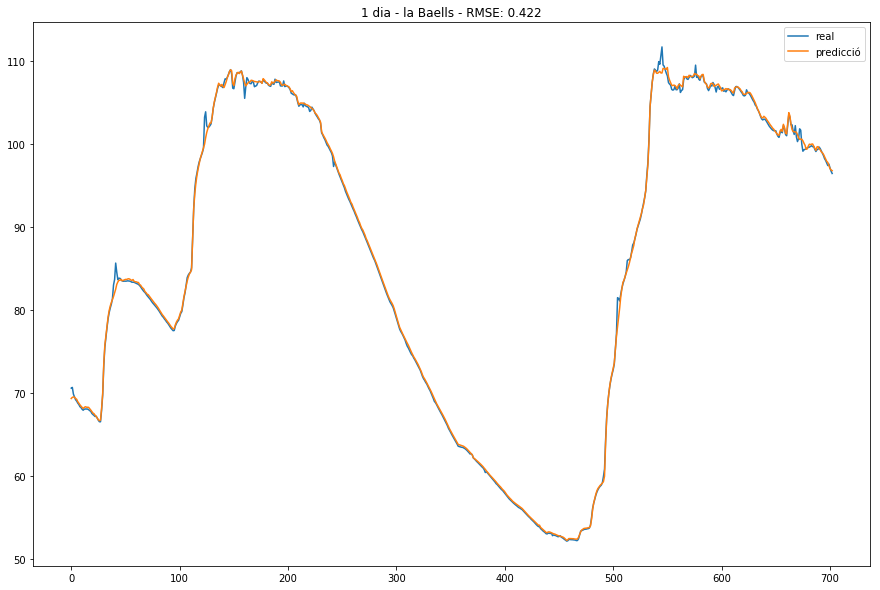

In [36]:
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - la Baells - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - la Baells - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - la Baells - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - la Baells - RMSE: '+str(round(RMSE_days[14],3))

plt.plot(dies[0][0], label='real')
plt.plot(dies[0][1], label='predicció')
plt.legend()
plt.title(title1)


plt.show()

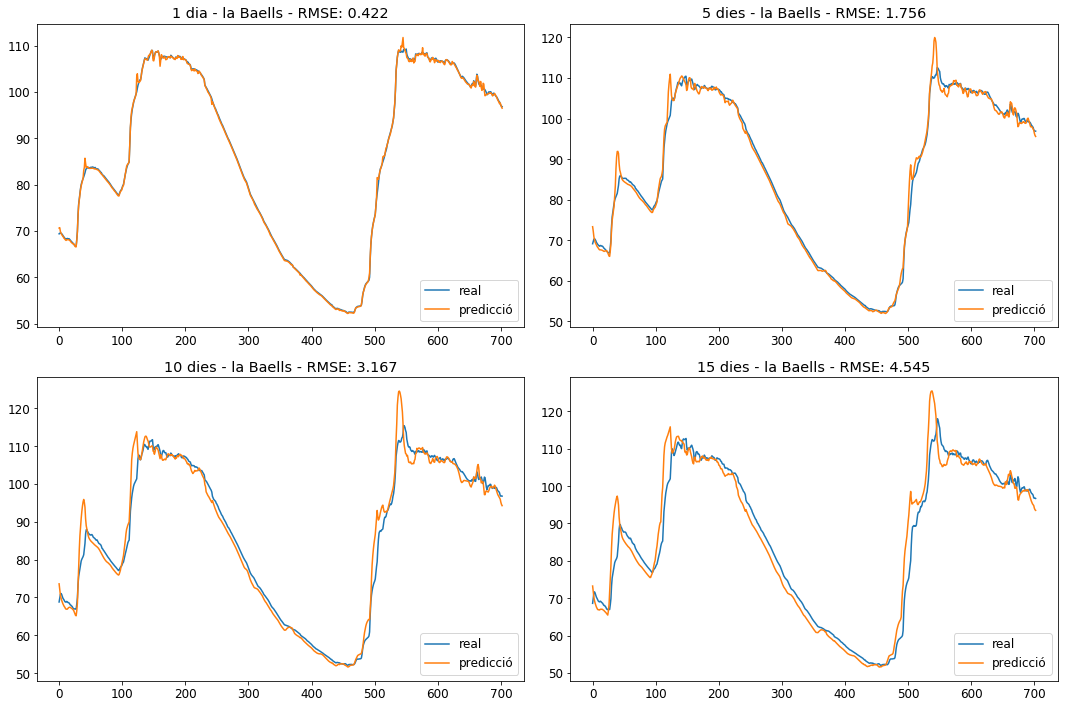

In [37]:
plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][1], label='real')
axes[0, 0].plot(dies[0][0], label='predicció')
axes[0, 0].legend(loc=4)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][1], label='real')
axes[0, 1].plot(dies[4][0], label='predicció')
axes[0, 1].legend(loc=4)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][1], label='real')
axes[1, 0].plot(dies[9][0], label='predicció')
axes[1, 0].legend(loc=4)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][1], label='real')
axes[1, 1].plot(dies[14][0], label='predicció')
axes[1, 1].legend(loc=4)


fig.tight_layout()
plt.show()

Repetim optimització al voltant dels millors paràmetres que acabem de trobar. Degut a problemes computacionals i baixades de rendiment, podeu veure que hem hagut de parar l'execució del procés, del qual recuperem els resultats de forma "manual", per no perdre'ls i seguim des d'allà on érem.

In [ ]:
model_list=[]
dense=np.arange(5,16,1)
epochs=np.arange(500,701,10)
resultatsf=[]
n_test = len(test_X)
for den in dense:
    resultat=[]
    for epoch in epochs:
        model = Sequential()
        model.add(Dense(den, activation='sigmoid', input_dim=n_steps_in))
        model.add(Dense(n_steps_out))
        model.compile(loss='mse', optimizer='adam')
        # fit model
        model.fit(train_X, train_Y, epochs=epoch, verbose=0)
        testPredict = model.predict(test_X)
        # invertim prediccions per tenir-les en l'escala original
        testPredict = inverse_transform(dataset, testPredict, scaler, n_test+2)
        test_YR = test_Y
        test_YR = inverse_transform(dataset, test_YR, scaler, n_test+2)
        test_YR = np.array(test_YR)
        testPredict = np.array(testPredict)
        RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
        print(RMSE_TOT)
        resultat.append((den,epoch,RMSE_days,RMSE_TOT))
    
    resultatsf.append(resultat)

2.8930116440624056
2.8506438147173405
2.8696717354325783
2.85569852016734
2.8505593403499683
2.87070841376741
2.9631374912606163
2.897676846206544
2.8870984809761824
2.8653465410262156
2.859400681343859
2.8541089537045883
2.906524973340896
2.8741241447803496
2.8569008384108634
2.87880753201677
2.860501093682365
2.8615324292462474
2.8713654473909624
2.8589317103232794
2.8542429410298027
2.858364739722789
2.856251662773466
2.8581428582997224
2.8574737731851396
2.859819388121953
2.9845585791561455
2.8904217622809285
2.849699901374365
2.8770926778992854
2.8484789754805777
2.8956739715710036
2.9121242755634045
2.8542173803422974
2.8561570033453676
2.8572075972715476
2.8589790778873936
2.869875611856175
2.858170385878336
2.8854268942604633
2.864418959091977
2.8728706103518205
2.868051175372515
2.866830746442412
2.867703342029252
2.8624461206421166
2.8827787567893073
2.9330269053825186
2.8918520410870023
2.9199798476163905
2.862014802682531
2.8816595485666268
2.910738524487311
2.8620397939094

In [12]:
model_list=[]
dense=np.arange(10,16,1)
epochs=np.arange(500,701,10)
resultatsf=[]
n_test = len(test_X)
for den in dense:
    resultat=[]
    for epoch in epochs:
        model = Sequential()
        model.add(Dense(den, activation='sigmoid', input_dim=n_steps_in))
        model.add(Dense(n_steps_out))
        model.compile(loss='mse', optimizer='adam')
        # fit model
        model.fit(train_X, train_Y, epochs=epoch, verbose=0)
        testPredict = model.predict(test_X)
        # invertim prediccions per tenir-les en l'escala original
        testPredict = inverse_transform(dataset, testPredict, scaler, n_test+2)
        test_YR = test_Y
        test_YR = inverse_transform(dataset, test_YR, scaler, n_test+2)
        test_YR = np.array(test_YR)
        testPredict = np.array(testPredict)
        RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
        print(RMSE_TOT)
        resultat.append((den,epoch,RMSE_days,RMSE_TOT))
    
    resultatsf.append(resultat)

2.862707145558712
2.8711777862913963
2.895431728553508
2.854053819936177
2.9196937293290706
2.876966881702938
2.8625490675806136
2.8754414758485822
2.8902270893778965
2.8756671628988815
2.878397219828206
2.8890186692291873
2.8553600368861685
2.880154508578686
2.901993125796967
2.943834657524897
2.867109500333368
2.9616761104137646
2.8508622655336153
2.8665228548867163
2.8576826913926356
2.8550442276984533
2.86145644176871
2.858267147384133
2.8697287292409976
2.854089907614094
2.8526617570326525
2.936276282415748
2.878363590519536
2.9162893505360206
2.991435860432257
2.854111459759665
2.9277540820821897
2.8682102801008966
2.8640555340588025
2.8593936773638635
2.84811033545229
2.9795818084071333
2.8597091729676074
2.9212131668661176
2.8529554335479106
2.8639216728155223
2.8827876888541044
2.8775109645657806
2.8740924563790466
2.8764651338508807
2.9991328257688092
2.871395837370843
2.8588825072689943
2.8546854554718664
2.853552387896313
2.8518586305461575
2.869833907262481
2.8812269693972

In [58]:
#print(resultatsEpDe[5][2])
varlist = []
for i in range(len(dense)):
    resultatsEpDe = pd.DataFrame(resultatsf[i])
    varlist.append(resultatsEpDe)
    
resultFinal = pd.concat(varlist)
resultFinal.columns=['neurones', 'epochs', 'RMSE_dies', 'RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]

,neurones,epochs,RMSE_dies,RMSE_total
0,14,630,"[0.42303880241772246, 0.788655128697986, 1.116...",2.840323
1,11,650,"[0.41421284735066705, 0.786494504757822, 1.124...",2.848110
2,12,630,"[0.4289344778308791, 0.7941902036337908, 1.137...",2.850427
3,13,670,"[0.4204381031844665, 0.7922407294152588, 1.126...",2.850584
4,10,680,"[0.42814901799681065, 0.7928603525722737, 1.13...",2.850862
5,12,590,"[0.4194398109055194, 0.8019804000861523, 1.131...",2.851859
6,11,550,"[0.4249103809281293, 0.7968229763028407, 1.126...",2.852662
7,11,690,"[0.42111269637534715, 0.8087914266692233, 1.13...",2.852955
8,12,580,"[0.421314732844309, 0.7933298425704494, 1.1220...",2.853552
9,15,640,"[0.42773836386575614, 0.7839412873140222, 1.12...",2.853571


In [59]:
#print(resultatsEpDe[5][2])
varlist = []
for i in range(len(dense)):
    resultatsEpDe = pd.DataFrame(resultatsf[i])
    varlist.append(resultatsEpDe)
    
resultFinal = pd.concat(varlist)
resultFinal.columns=['neurones', 'epochs', 'RMSE_dies', 'RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]

,neurones,epochs,RMSE_dies,RMSE_total
0,14,630,"[0.42303880241772246, 0.788655128697986, 1.116...",2.840323
1,11,650,"[0.41421284735066705, 0.786494504757822, 1.124...",2.848110
2,12,630,"[0.4289344778308791, 0.7941902036337908, 1.137...",2.850427
3,13,670,"[0.4204381031844665, 0.7922407294152588, 1.126...",2.850584
4,10,680,"[0.42814901799681065, 0.7928603525722737, 1.13...",2.850862
5,12,590,"[0.4194398109055194, 0.8019804000861523, 1.131...",2.851859
6,11,550,"[0.4249103809281293, 0.7968229763028407, 1.126...",2.852662
7,11,690,"[0.42111269637534715, 0.8087914266692233, 1.13...",2.852955
8,12,580,"[0.421314732844309, 0.7933298425704494, 1.1220...",2.853552
9,15,640,"[0.42773836386575614, 0.7839412873140222, 1.12...",2.853571


In [60]:
den2=np.arange(5,16,1)
epo2=np.arange(500,701,10)
res = [2.8930116440624056,
2.8506438147173405,
2.8696717354325783,
2.85569852016734,
2.8505593403499683,
2.87070841376741,
2.9631374912606163,
2.897676846206544,
2.8870984809761824,
2.8653465410262156,
2.859400681343859,
2.8541089537045883,
2.906524973340896,
2.8741241447803496,
2.8569008384108634,
2.87880753201677,
2.860501093682365,
2.8615324292462474,
2.8713654473909624,
2.8589317103232794,
2.8542429410298027,
2.858364739722789,
2.856251662773466,
2.8581428582997224,
2.8574737731851396,
2.859819388121953,
2.9845585791561455,
2.8904217622809285,
2.849699901374365,
2.8770926778992854,
2.8484789754805777,
2.8956739715710036,
2.9121242755634045,
2.8542173803422974,
2.8561570033453676,
2.8572075972715476,
2.8589790778873936,
2.869875611856175,
2.858170385878336,
2.8854268942604633,
2.864418959091977,
2.8728706103518205,
2.868051175372515,
2.866830746442412,
2.867703342029252,
2.8624461206421166,
2.8827787567893073,
2.9330269053825186,
2.8918520410870023,
2.9199798476163905,
2.862014802682531,
2.8816595485666268,
2.910738524487311,
2.8620397939094744,
2.880297714051418,
2.862177574956008,
2.8565371245928604,
2.867785814935746,
2.8920987058391363,
2.861977148821845,
2.8921351431667803,
2.87065226994773,
2.861702227303943,
2.8631043841392754,
2.88359212283634,
2.8629283401309746,
2.8865149068548246,
2.869232197047449,
2.8562321301324882,
2.8668245922619424,
2.8598977533483487,
2.8608803043867166,
2.8796195359057113,
2.926697856096756,
2.874679713445486,
2.8627379605862364,
2.89173117427349,
2.86418123139611,
2.938095681685879,
2.8679590668251134,
2.8879816289407247,
2.864980404239234,
2.853607197153198,
2.854492354547977,
2.8508487173864254,
2.884072790711355,
2.9169223854951865,
2.856422776353407,
2.944879231850696,
2.9090921594335297,
2.888571344758049,
2.863851576310346,
2.874232811775452,
2.974388149398335,
2.8529676345930817,
2.8753444631131027,
2.8623748218868332,
2.848305543154225,
2.8505319065515744,
2.8511363926069984,
2.8538309349984625,
2.8810525292768676,
2.8654711832845026,
2.8602460357902615,
2.8652585060440043,
2.855778668202039,
2.9145073845115848,
2.8656966571730194,
2.876534757216164,
2.881190063117942,
2.8540077072392354,
2.8664656309858394,
2.86633554217011,
2.8714958065107954,
2.854247618777901,
2.9189147641321345,
2.8749736287109995,
2.8561783729436945,
2.856359841135781]
comb = []
for i in den2:
    for j in epo2:
        comb.append((i,j))

comres =  comb[0:119]

resultatsf_aux = []
for i in range (len(comres)):
    resultatsf_aux.append((res[i],comres[i]))

aux = []
for x in resultatsf_aux:
    var1 = x[0]
    var2 = x[1][0]
    var3 = x[1][1]
    aux.append((var2, var3, var1))
    


In [61]:
    
resultFinalAux = pd.DataFrame(aux)
resultFinalAux.columns=['neurones', 'epochs', 'RMSE_total' ]
resultFinalAux = resultFinalAux.sort_values(by='RMSE_total', ascending=True)
resultFinalAux = resultFinalAux.reset_index(drop=True)

resultFinalAux[0:15]

,neurones,epochs,RMSE_total
0,9,630,2.848306
1,6,590,2.848479
2,6,570,2.849700
3,9,640,2.850532
4,5,540,2.850559
5,5,510,2.850644
6,9,500,2.850849
7,9,650,2.851136
8,9,600,2.852968
9,8,690,2.853607


In [62]:
resultatf_aux = resultFinal.drop(['RMSE_dies'], axis=1)

In [63]:
resultFinal2 = pd.concat([resultatf_aux, resultFinalAux])


In [64]:
resultFinal2 = resultFinal2.sort_values(by='RMSE_total', ascending=True)
resultFinal2 = resultFinal2.reset_index(drop=True)
resultFinal2[0:15]

,neurones,epochs,RMSE_total
0,14,630,2.840323
1,11,650,2.848110
2,9,630,2.848306
3,6,590,2.848479
4,6,570,2.849700
5,12,630,2.850427
6,9,640,2.850532
7,5,540,2.850559
8,13,670,2.850584
9,5,510,2.850644


In [66]:
import statistics
model_list=[]
config=[(14,630), (11,650), (9,630), (6, 590), (6, 570), (12,630)]
resultatsf=[]
n_test = len(test_X)

for conf in config:
    resultat=[]
    for i in range(10):    
        model = Sequential()
        model.add(Dense(conf[0], activation='sigmoid', input_dim=n_steps_in))
        model.add(Dense(n_steps_out))
        model.compile(loss='mse', optimizer='adam')
        # fit model
        model.fit(train_X, train_Y, epochs=conf[1], verbose=0)
        testPredict = model.predict(test_X)
        # invertim prediccions per tenir-les en l'escala original
        testPredict = inverse_transform(dataset, testPredict, scaler, n_test+2)
        test_YR = test_Y
        test_YR = inverse_transform(dataset, test_YR, scaler, n_test+2)
        test_YR = np.array(test_YR)
        testPredict = np.array(testPredict)
        RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
        print(RMSE_TOT)
        resultat.append(RMSE_TOT)
    
    resMean = round(statistics.mean(resultat),4)
    resDesv = round(statistics.stdev(resultat),4)
    resultatsf.append((conf[0], conf[1], resMean, resDesv))

2.866269996463514
2.890443703404595
2.8627777697793912
2.8729227273908
2.9192065124957596
2.8529649603958656
2.8652042525150576
2.8573000524056864
2.875822530096281
2.862135091785566
2.930800895204091
2.8576259579268735
2.863271424405464
2.870452435549737
2.85718890561734
2.854122820515081
2.8541632510719372
2.8814838107685405
2.8488099072908355
2.857477277530228
2.8619066714591828
2.9294083525865107
2.8883689530677015
2.8674848438717135
2.8884356481440325
2.8620744480497358
2.876383407131563
2.85606918597368
2.8531402821460587
2.8804160808303467
2.8699404106200976
2.8923611762413293
2.897210779245694
2.8684069459532364
2.8695464447724235
2.851641259346848
2.8924226686893713
2.910014186182215
2.888222515653314
2.8594984017514578
2.8760054115700777
2.875696015072865
2.896839122694078
2.846966946537619
2.8549822642081106
2.9027007385284507
2.8545686944502577
2.871666509886959
2.8913784385483585
2.8785935210063416
2.863916178377087
2.851105117695747
2.857988532116081
2.854753939685931
2.8

In [67]:
import numpy as np
import pandas as pd
resultatsEpDe3 = pd.DataFrame(resultatsf)
resultatsEpDe3.columns=['neurones', 'epochs', 'mean_RMSE', 'std_RMSE' ]
resultatsEpDe3 = resultatsEpDe3.sort_values(by='mean_RMSE', ascending=True)
display(resultatsEpDe3)

,neurones,epochs,mean_RMSE,std_RMSE
5,12,630,2.8626,0.0150
1,11,650,2.8675,0.0241
0,14,630,2.8725,0.0195
4,6,570,2.8749,0.0187
2,9,630,2.8764,0.0225
3,6,590,2.8799,0.0187


In [69]:
model = Sequential()
model.add(Dense(12, activation='sigmoid', input_dim=n_steps_in))
model.add(Dense(n_steps_out))
model.compile(loss='mse', optimizer='adam')
# fit model
model.fit(train_X, train_Y, epochs=630, verbose=0)
testPredict = model.predict(test_X)
# invertim prediccions per tenir-les en l'escala original
testPredict = inverse_transform(dataset, testPredict, scaler, n_test+2)
test_YR = test_Y
test_YR = inverse_transform(dataset, test_YR, scaler, n_test+2)
test_YR = np.array(test_YR)
testPredict = np.array(testPredict)
RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
print(RMSE_TOT)

2.855786181964968


In [70]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_days)):
    headers.append('dia '+str(i+1))

print(RMSE_days)
headers.append('Total')
v = RMSE_days
ultim = v.append(RMSE_TOT)
table1 = tabulate([RMSE_days[0:5]], headers[0:5], tablefmt="fancy_grid")
table2 = tabulate([RMSE_days[5:10]], headers[5:10], tablefmt="fancy_grid")
table3 = tabulate([RMSE_days[10:16]], headers[10:16], tablefmt="fancy_grid")
#output
print(table1)
print(table2)
print(table3)

[0.42951368804587037, 0.8056308069012448, 1.1319194035532927, 1.4470442835603183, 1.7495280038010208, 2.049631839350639, 2.3354428383151657, 2.610144221972623, 2.8917844354428177, 3.1667842508537074, 3.4399995905853737, 3.7064042520829266, 3.9801700917995655, 4.260655900849579, 4.542939990437235]
╒══════════╤══════════╤═════════╤═════════╤═════════╕
│    dia 1 │    dia 2 │   dia 3 │   dia 4 │   dia 5 │
╞══════════╪══════════╪═════════╪═════════╪═════════╡
│ 0.429514 │ 0.805631 │ 1.13192 │ 1.44704 │ 1.74953 │
╘══════════╧══════════╧═════════╧═════════╧═════════╛
╒═════════╤═════════╤═════════╤═════════╤══════════╕
│   dia 6 │   dia 7 │   dia 8 │   dia 9 │   dia 10 │
╞═════════╪═════════╪═════════╪═════════╪══════════╡
│ 2.04963 │ 2.33544 │ 2.61014 │ 2.89178 │  3.16678 │
╘═════════╧═════════╧═════════╧═════════╧══════════╛
╒══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   dia 11 │   dia 12 │   dia 13 │   dia 14 │   dia 15 │   Total │
╞══════════╪══════════╪══════════

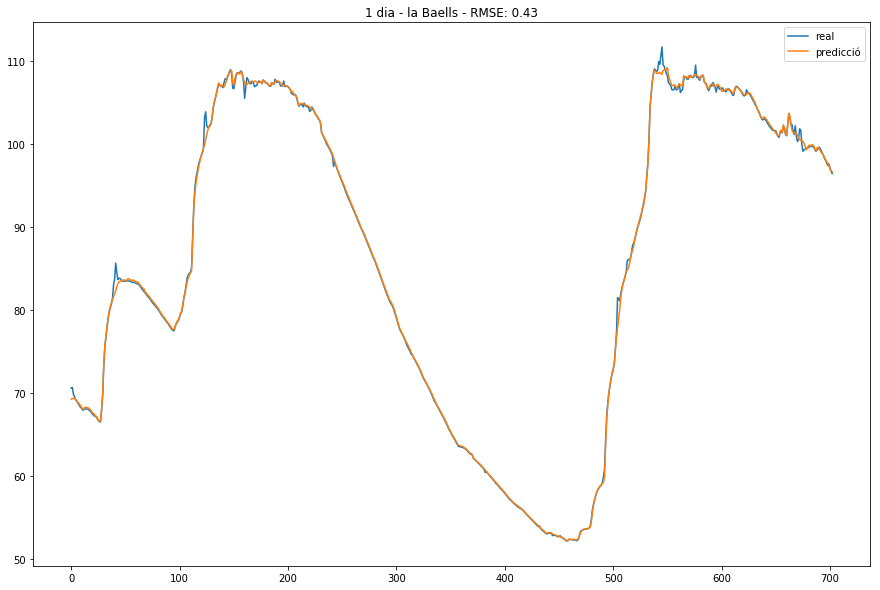

In [71]:
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - la Baells - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - la Baells - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - la Baells - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - la Baells - RMSE: '+str(round(RMSE_days[14],3))

plt.plot(dies[0][0], label='real')
plt.plot(dies[0][1], label='predicció')
plt.legend()
plt.title(title1)


plt.show()

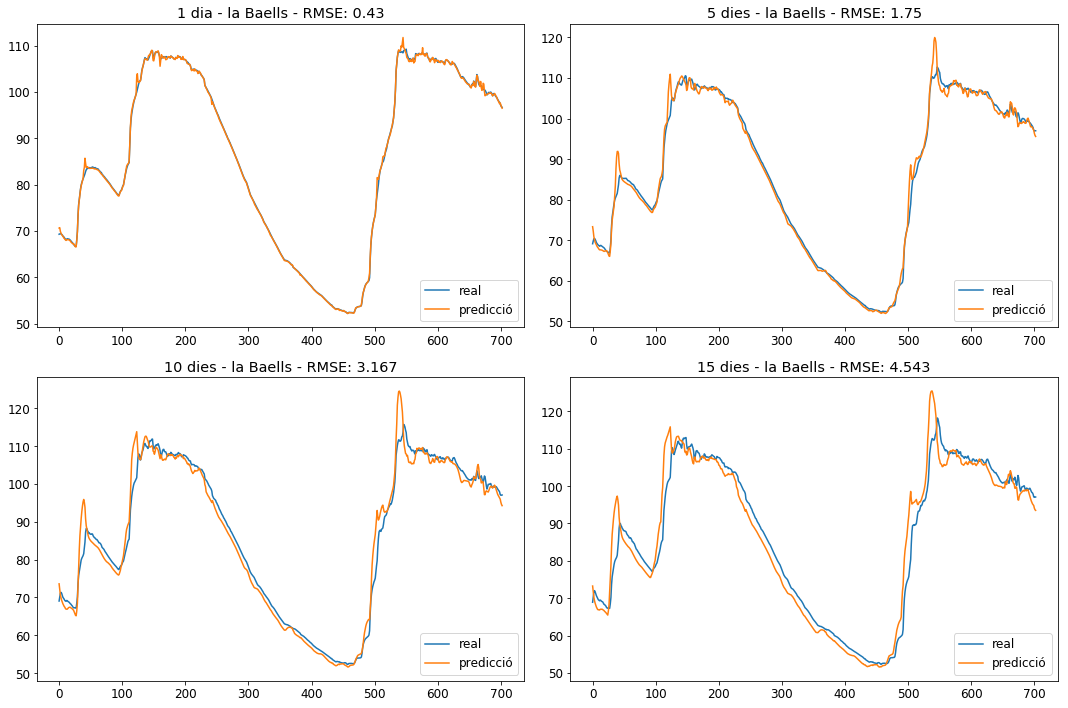

In [72]:
plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][1], label='real')
axes[0, 0].plot(dies[0][0], label='predicció')
axes[0, 0].legend(loc=4)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][1], label='real')
axes[0, 1].plot(dies[4][0], label='predicció')
axes[0, 1].legend(loc=4)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][1], label='real')
axes[1, 0].plot(dies[9][0], label='predicció')
axes[1, 0].legend(loc=4)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][1], label='real')
axes[1, 1].plot(dies[14][0], label='predicció')
axes[1, 1].legend(loc=4)


fig.tight_layout()
plt.show()

Optimtizem per learning rate i batch size:

In [25]:
from keras import optimizers
n_test = len(test_X)
lr=np.arange(0.0001,0.01,0.0005)
batch=[8,16,32,64,128]
resultatsf=[]
for learn in lr:
    adam = optimizers.Adam(lr=learn)
    resultat=[]
    for batch_size in batch:
        model = Sequential()
        model.add(Dense(12, activation='sigmoid', input_dim=n_steps_in))
        model.add(Dense(n_steps_out))
        model.compile(loss='mse', optimizer=adam)
        # fit model
        modelfit = model.fit(train_X, train_Y, epochs=630, batch_size=batch_size, verbose=0)
        testPredict = model.predict(test_X)
        # invertim prediccions per tenir-les en l'escala original
        testPredict = inverse_transform(dataset, testPredict, scaler, n_test+2)
        test_YR = test_Y
        test_YR = inverse_transform(dataset, test_YR, scaler, n_test+2)
        test_YR = np.array(test_YR)
        testPredict = np.array(testPredict)
        RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
        print((RMSE_TOT, learn, batch_size))
        resultat.append((learn, batch_size,RMSE_days,RMSE_TOT))
    
    resultatsf.append(resultat)

(2.916894268056439, 0.0001, 8)
(2.9160347571898315, 0.0001, 16)
(3.0073830037813782, 0.0001, 32)
(3.0828432432518165, 0.0001, 64)
(3.2996840239017997, 0.0001, 128)
(2.8777625038923196, 0.0006000000000000001, 8)
(2.8909463239903572, 0.0006000000000000001, 16)
(2.862641350200533, 0.0006000000000000001, 32)
(2.8574121961344963, 0.0006000000000000001, 64)
(2.887838474268739, 0.0006000000000000001, 128)
(2.8734403609178085, 0.0011, 8)
(2.895170689427974, 0.0011, 16)
(2.878957098378543, 0.0011, 32)
(2.854601601830942, 0.0011, 64)
(2.8626908217881133, 0.0011, 128)
(2.8707805021506467, 0.0016, 8)
(2.8376478181895095, 0.0016, 16)
(2.8441324500831047, 0.0016, 32)
(2.8651514957977477, 0.0016, 64)
(2.866212268419623, 0.0016, 128)
(2.9770428928185018, 0.0021, 8)
(2.8326688061989866, 0.0021, 16)
(2.8908819960714345, 0.0021, 32)
(2.855855808561068, 0.0021, 64)
(2.877813869562568, 0.0021, 128)
(2.9206135520653556, 0.0026, 8)
(2.908612347383803, 0.0026, 16)
(2.838504858682414, 0.0026, 32)
(2.9614880535

In [27]:
varlist = []
for i in range(len(lr)):
    resultatsEpDe = pd.DataFrame(resultatsf[i])
    varlist.append(resultatsEpDe)
    
resultFinal = pd.concat(varlist)
resultFinal.columns=['learning rate', 'batch size', 'RMSE_dies', 'RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]

,learning rate,batch size,RMSE_dies,RMSE_total
0,0.0041,8,"[0.39570543038091127, 0.7620992639321583, 1.09...",2.811702
1,0.0021,16,"[0.39405287643891024, 0.7667452732160636, 1.10...",2.832669
2,0.0091,8,"[0.4326220957733786, 0.8258078203645397, 1.153...",2.832764
3,0.0016,16,"[0.4144473536572238, 0.7940880528661814, 1.118...",2.837648
4,0.0026,32,"[0.41123062383811415, 0.7826876953899697, 1.12...",2.838505
5,0.0066,16,"[0.4181824966493953, 0.7958875035196036, 1.130...",2.839293
6,0.0041,32,"[0.41585933632987526, 0.7828051157467926, 1.11...",2.840954
7,0.0076,64,"[0.4214105875586223, 0.8014660767975352, 1.139...",2.843434
8,0.0056,16,"[0.4047234353566074, 0.7781001872200833, 1.107...",2.843458
9,0.0046,16,"[0.4276116425870909, 0.7945244472816341, 1.133...",2.843520


In [28]:
from keras import optimizers
n_test = len(test_X)
lr=np.arange(0.0030,0.0051,0.0002)
batch=[4,6,8,10,12]
resultatsf=[]
for learn in lr:
    adam = optimizers.Adam(lr=learn)
    resultat=[]
    for batch_size in batch:
        model = Sequential()
        model.add(Dense(12, activation='sigmoid', input_dim=n_steps_in))
        model.add(Dense(n_steps_out))
        model.compile(loss='mse', optimizer=adam)
        # fit model
        modelfit = model.fit(train_X, train_Y, epochs=630, batch_size=batch_size, verbose=0)
        testPredict = model.predict(test_X)
        # invertim prediccions per tenir-les en l'escala original
        testPredict = inverse_transform(dataset, testPredict, scaler, n_test+2)
        test_YR = test_Y
        test_YR = inverse_transform(dataset, test_YR, scaler, n_test+2)
        test_YR = np.array(test_YR)
        testPredict = np.array(testPredict)
        RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
        print((RMSE_TOT, learn, batch_size))
        resultat.append((learn, batch_size,RMSE_days,RMSE_TOT))
    
    resultatsf.append(resultat)

(2.9490009555860377, 0.003, 4)
(2.808980137929637, 0.003, 6)
(2.8960416613685522, 0.003, 8)
(2.8102967003134607, 0.003, 10)
(2.812021426703919, 0.003, 12)
(2.9908795000326944, 0.0032, 4)
(2.860405074557056, 0.0032, 6)
(2.8705559259231546, 0.0032, 8)
(2.8642581454568505, 0.0032, 10)
(2.8744725282517187, 0.0032, 12)
(2.9230282389490116, 0.0034000000000000002, 4)
(2.866891455893133, 0.0034000000000000002, 6)
(2.8603567303747273, 0.0034000000000000002, 8)
(2.833692602679319, 0.0034000000000000002, 10)
(2.8880569185158733, 0.0034000000000000002, 12)
(2.8286427398048493, 0.0036000000000000003, 4)
(2.9043919355975296, 0.0036000000000000003, 6)
(2.848033989864214, 0.0036000000000000003, 8)
(2.8282050864329644, 0.0036000000000000003, 10)
(2.961871399966819, 0.0036000000000000003, 12)
(2.875579443879359, 0.0038000000000000004, 4)
(2.901223707166243, 0.0038000000000000004, 6)
(2.8949280748672814, 0.0038000000000000004, 8)
(2.884940336460025, 0.0038000000000000004, 10)
(2.868819684281396, 0.003800

In [29]:
varlist = []
for i in range(len(lr)):
    resultatsEpDe = pd.DataFrame(resultatsf[i])
    varlist.append(resultatsEpDe)
    
resultFinal = pd.concat(varlist)
resultFinal.columns=['learning rate', 'batch size', 'RMSE_dies', 'RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]

,learning rate,batch size,RMSE_dies,RMSE_total
0,0.0044,12,"[0.40708399410773344, 0.7743987843183756, 1.12...",2.807100
1,0.0030,6,"[0.4036903807966506, 0.783183756372395, 1.1188...",2.808980
2,0.0030,10,"[0.40448008638457994, 0.7617873332130521, 1.09...",2.810297
3,0.0030,12,"[0.40959754311227065, 0.7747307571207562, 1.11...",2.812021
4,0.0040,10,"[0.40496041952213935, 0.7807464502689359, 1.11...",2.814800
5,0.0036,10,"[0.4179939012892497, 0.7931153110306133, 1.128...",2.828205
6,0.0036,4,"[0.4197529830179099, 0.7872748567782435, 1.116...",2.828643
7,0.0034,10,"[0.4315606125079734, 0.7937718726320935, 1.135...",2.833693
8,0.0048,6,"[0.42887668403488316, 0.8441914357326407, 1.15...",2.837388
9,0.0036,8,"[0.4179560222648671, 0.8040073446132866, 1.162...",2.848034
